In [1]:
import pyecap
import os
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.io as sio
from scipy.signal import find_peaks
from fnirs_functions import *

mpl.rcParams['lines.linewidth'] = 0.75
mpl.rcParams['axes.linewidth'] = 0.75

In [2]:
meta_index = 2

#tank = r'G:\Data\fNIRs_qc\20260213_fNIRs_QC\CVP_SingleCh_Ramp-260213\\' + metaDF.at[meta_index, 'Tank']
#flex_folder = r'G:\Data\fNIRs_qc\20260213_fNIRs_QC\flexNIRs\\' + metaDF.loc[meta_index, 'fNIRs Run'] + '.mat'

metaDF = pd.read_excel(r'D:\Data\TDT_fNIRs\20260213_fNIRs_QC\metadata.xlsx')
tank = r'D:\Data\TDT_fNIRs\20260213_fNIRs_QC\CVP_SingleCh_Ramp-260213\\' + metaDF.at[meta_index, 'Tank']
flex_folder = r'D:\Data\TDT_fNIRs\20260213_fNIRs_QC\flexNIRs\\' + metaDF.loc[meta_index, 'fNIRs Run'] + '.mat'

fd = flexNIRs(flex_folder)

ecg_data = pyecap.Ephys(tank, stores = 'ECGG')
ecg_data = ecg_data.remove_ch(channels=['ECGG 2','ECGG 3', 'ECGG 4'])

stim = pyecap.Stim(tank)
stimDF = stim.parameters

In [3]:
"""Align fNIRs Artifact"""
alignDF = stimDF.loc[stimDF['pulse amplitude (μA)'] < 0]
fd.manual_alignment(stimDF = alignDF, stim_start_index = int(60.5*266.6))
fd.plot_artifact(channel = 'D1 Ambient', fc = 1, filter_type = 'highpass', show_stim = True)

In [4]:
"""Performs short-channel regression to generate SSR-DF"""
data_type = 'Hemo_filt' # Data type of original data to run SSR regression on
fd.ssr_regression(data_type = data_type)
#fd.ssr_plot(data_type, channel = 'D1 LL',wv = 'HbT', show_stim=True, show_ss=True)

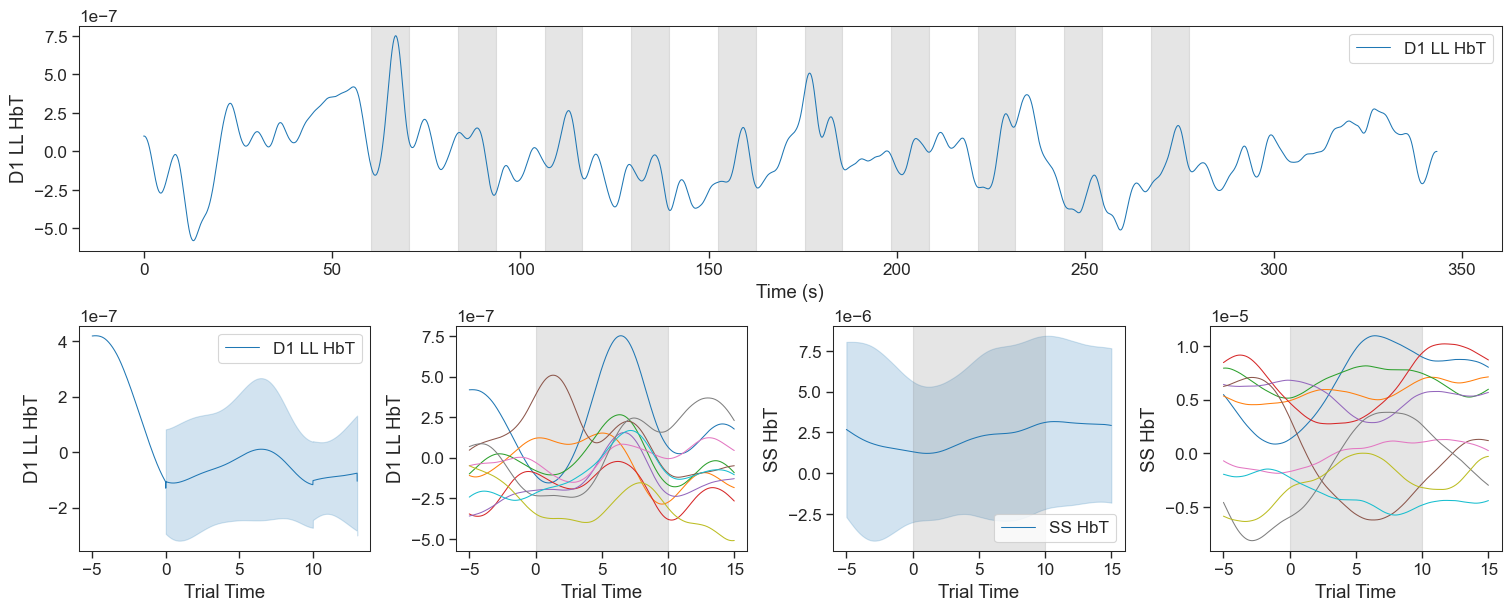

In [5]:
fig = plt.figure(layout='constrained', figsize=(15,6))
d_type = 'SSR_filt'
chan = 'D1 LL'
color = 'HbT'
z_shift = False

mosaic = [['full','full', 'full', 'full'],
      ['avg', 'channel stack','avg SS', 'SS stack']]

ax_dict = fig.subplot_mosaic(mosaic)

fd.plot_channel(data_type =d_type, channel  = chan, wv = color, plot_style = 'full', fig_size = (12,6), show = False, axis = ax_dict['full'])
fd.plot_channel(data_type = d_type, channel  = chan, wv = color, plot_style = 'interstim mean', pre_time = 5, post_time = 5, fig_size = (12,6), zero_shift = z_shift, show = False, axis = ax_dict['avg'])
fd.plot_channel(data_type = d_type, channel  = chan, wv = color, plot_style = 'stacked', pre_time = 5, post_time = 5, fig_size = (12,6), zero_shift = z_shift, show = False, axis = ax_dict['channel stack'])

fd.plot_channel(data_type = fd.SSR_dtype, channel  = 'SS', wv = color, plot_style = 'mean', pre_time = 5, post_time = 5, fig_size = (12,6), zero_shift = z_shift, show = False, axis = ax_dict['avg SS'])
fd.plot_channel(data_type = fd.SSR_dtype, channel  = 'SS', wv = color, plot_style = 'stacked', pre_time = 5, post_time = 5, fig_size = (12,6), zero_shift = z_shift, show = False, axis = ax_dict['SS stack'])
# fd.plot_channel(data_type = 'Mua_filt', channel  = chan, wv = color, plot_style = 'full', pre_time = 5, post_time = 5, fig_size = (12,6), zero_shift = True, show = False, axis = ax_dict['full'])
plt.show()

In [ ]:
"""Plot for data presentation
Plots of interest:
HbO/HbR or each channel with different stims
Priority: HbT of each channel of different stim parameters overlaid on top of each to assess differences in stim amplitude effects?
Plot showing effect of SSR regression data
Add HR as a secondary plot?

Add averages of inter-stim "off" periods between to gigaplots

gigaplot #1
Top most trace = Full recording (with or without SS data?)
Middle Plot = ECG?
Bottom rows of plots
Row #1
a: average of stim
b: stacked stim traces
c: average of SS channel
d: stacked SS channel
Row #2
a: average of baseline following interested channel
b: stacked during baseline
c: average of ss channel during baseline
d: stacked SS during baseline

gigaplot #2 - side-by-side stims
Single row of plots where each plot is a stimulation with the original data, ssr data, and SS data
"""

In [ ]:
plotDF = fd.get_data(data_type = 'Mua_filt')
stimDF = fd.stimDF

onset_indices = stimDF['fNIRs onset index'].values
offset_indices = stimDF['fNIRs offset index'].values

interstim_idx = [ (offset_indices[i], onset_indices[i+1]) for i in np.arange(len(onset_indices)-1)]
interstim_sample_len = [idx2 - idx1 for idx1,idx2 in interstim_idx]
interstim_idx.append( (offset_indices[-1], offset_indices[-1] + interstim_sample_len[0] ))
# for idx, stim in enumerate(stimDF.index):
#
#     #Start case
#     if idx == 0:
#         idx1 = stimDF.loc[stim, 'fNIRs offset index']
#         idx2 = stimDF.loc[stim, 'fNIRs onset index']
#
#     print(stim)

    #
    # stim_start_idx = stimDF.loc[stim, 'fNIRs onset index']
    # stim_stop_idx = stimDF.loc[stim, 'fNIRs offset index']
    #
    # plotDF.loc[plot_start_idx:plot_stop_idx, 'Stim #'] = str(idx + 1)
    #
    # # Construct time array based on sampling frequency and number of indices with time zero at stimulation start
    # time_span = plot_stop_idx - plot_start_idx + 1
    # time = np.arange(-pre_BL_idx_width, time_span - pre_BL_idx_width, 1) / fs
    #
    # plotDF.loc[plot_start_idx:plot_stop_idx, 'Trial Time'] = time
    #

    #End case

In [ ]:
interstim_sample_len = [idx2 - idx1 for idx1,idx2 in interstim_idx]
interstim_idx.append( (offset_indices[-1], offset_indices[-1] + interstim_sample_len[0] ))

In [ ]:
onset_indices = stimDF['fNIRs onset index'].values
offset_indices = stimDF['fNIRs offset index'].values

interstim_idx = [(offset_indices[i], onset_indices[i + 1]) for i in np.arange(len(onset_indices) - 1)]
interstim_sample_len = [idx2 - idx1 for idx1, idx2 in interstim_idx]
interstim_idx.append((offset_indices[-1], offset_indices[-1] + interstim_sample_len[-1]))

for idx, (start, stop) in enumerate(interstim_idx):
    plotDF.loc[start:stop, 'Interstim #'] = str(idx + 1)

    # Construct time array based on sampling frequency and number of indices with time zero at stimulation start
    time_span = stop - start + 1
    time = np.arange(0, time_span, 1) / fd.fs

    plotDF.loc[start:stop, 'Trial Time'] = time

In [ ]:
data_type = 'SSR_filt'
channels = ['D1 LS', 'D1 LL', 'D3 LS', 'D3 LL']

for chan in channels:
    fd.gigaplot(data_type, channel = chan, pre_time=5, post_time=5,show_stim=True, fig_size = (12,6), zero_shift = True)

In [ ]:
channels = ['D1 LL', 'D1 LS']
color_chan = ['Red','IR']
chs = [ch + ' ' + color for color in color_chan for ch in channels]
chs

In [ ]:
channel = 'D1 LL'
channel_pair = [ fd.ch_dct[ch][0] + ' ' + fd.ch_dct[ch][1] + ' SSR' for ch in fd.ch_pairs[channel]]

channel_pair = [ch.replace('Red', 'HbO') for ch in channel_pair]
channel_pair = [ch.replace('IR', 'HbR') for ch in channel_pair]

print(channel_pair)

In [ ]:
fd.plot_channel(data_type = 'SSR_filt', channel = 'D3 LL', pre_time =5, post_time = 5, plot_style='Full', fig_size =(4,10), zero_shift = True)

In [ ]:
"""Perform HR calculations"""
#fNIRs HR
fd.calc_hr(channel = 'SS Red', filter_cutoffs=(0.5,15),peak_height = 2000, check_plot = False)

#Filter TDT ECG without Down-sampling
tdt_ecg = filter_hr(ecg_data, cutoff = 10, downsample=False, check_plot=False)
ecgDF = calc_hr(tdt_ecg, peak_height = 250, fs = ecg_data.sample_rate)

#Filter and down sample TDT ECG data for Plotting
DS_factor = 10
tdt_ecg_DS = filter_hr(ecg_data, cutoff = 10, downsample=True, downsample_factor = DS_factor, check_plot=False)
ecgDF_DS = calc_hr(tdt_ecg_DS, peak_height = 250, fs = ecg_data.sample_rate / DS_factor)

In [ ]:
"""Plot ECG"""
fig = go.Figure()
fig.add_trace(go.Scatter(x = ecgDF['Time (s)'], y = ecgDF['smooth bpm'], name = 'TDT HR'))
#fig.add_trace(go.Scatter(x = fd.ecgDF['Time (s)'], y = fd.ecgDF['b2b bpm'],name = 'fNIRs HR'))
#fig.add_trace(go.Scatter(x = ecgDF_DS['Time (s)'], y = ecgDF_DS['b2b bpm'], name = 'downsampled'))
for param in stimDF.index:
        fig.add_vrect(x0=fd.stimDF.loc[param]['onset time (s)'],
                  x1=fd.stimDF.loc[param]['offset time (s)'],
                      line_width=0, fillcolor='red', opacity=0.15)
fig.show()

In [ ]:
fd.plot_channel_interactive(data_type = 'SSR_filt', channel = 'D1 LL Red SSR', show_stim =True, show_hr=True, hr_chan='smooth')

In [ ]:
data_type = 'Mua_filt' # Data type of original data
fd.ssr_regression(data_type = data_type)
#fd.ssr_plot(data_type, channel = 'D1 LL Red', show_stim=True, show_ss=True)

In [ ]:
"""Plot for data presentation
Plots of interest:
HbO/HbR or each channel with different stims
Priority: HbT of each channel of different stim parameters overlaid on top of each to assess differences in stim amplitude effects?
Plot showing effect of SSR regression data
Add HR as a secondary plot?
"""
fd.plot_channel(data_type = 'SSR_filt', channel = 'D1 LL', pre_time =5, post_time = 5, plot_style='Full', fig_size =(4,10), zero_shift = True)

In [ ]:
"""Stacked ECG plot"""
#metaLIST = [5,2,3,4] #3 mA
#metaLIST = [6,8,7,9] #4 mA
metaLIST = [12,11,13,10] #6 mA

freqLIST = [17, 100,200,300] #3 mA

fig,ax = plt.subplots(nrows = 4, figsize = (10,10), layout='constrained')
ax = ax.ravel()

for idx, meta_index in enumerate(metaLIST):
    tank = r'G:\Data\fNIRs_qc\20260213_fNIRs_QC\CVP_SingleCh_Ramp-260213\\' + metaDF.at[meta_index, 'Tank']
    ecg_data = pyecap.Ephys(tank, stores = 'ECGG')
    ecg_data = ecg_data.remove_ch(channels=['ECGG 2','ECGG 3', 'ECGG 4'])
    stim = pyecap.Stim(tank)
    stimDF = stim.parameters

    #Filter TDT ECG without Down-sampling
    tdt_ecg = filter_hr(ecg_data, cutoff = 10, downsample=False, check_plot=False)
    ecgDF = calc_hr(tdt_ecg, peak_height = 250, fs = ecg_data.sample_rate)

    title = '6 mA, ' + str(freqLIST[idx]) + ' Hz'
    ax[idx].set_xlim( stimDF.loc[stimDF.index[0], 'onset time (s)'] - 60, stimDF.loc[stimDF.index[-1], 'offset time (s)'] + 60 )
    sns.lineplot(data = ecgDF, x = ecgDF['Time (s)'], y = ecgDF['smooth bpm'], ax=ax[idx], label = 'HR (bpm)').set_title(title)
    ax[idx].set_ylim(50,70)

    for param in stimDF.index:
        ax[idx].axvspan(xmin=stimDF.loc[param]['onset time (s)'],
                                            xmax=stimDF.loc[param]['offset time (s)'], color='red', alpha=0.1)

In [ ]:
fs = fd.fs
pre_time = 5
post_time = 5
zero_shift = True

ss_chan = 'SS HbT'

channels = ['D1 LS', 'D1 LL', 'D3 LS', 'D3 LL']

pre_BL_idx_width = int(pre_time * fs)
post_BL_idx_width = int(post_time * fs)

for chan in channels:

    plotDF = pd.DataFrame(fd.get_data('SSR_filt', chan, wv = 'HbT'))
    plotDF['Time (s)'] = fd.time

    #Add SS HbT channel
    ssDF = fd.get_data('Hemo_filt')
    ssDF['Time (s)'] = fd.time

    stimDF = fd.stimDF.copy()
    # Label data points based on stimulation #
    for idx, stim in enumerate(stimDF.index):
        stim_start_idx = stimDF.loc[stim, 'fNIRs onset index']
        stim_stop_idx = stimDF.loc[stim, 'fNIRs offset index']

        plot_start_idx = (stim_start_idx - pre_BL_idx_width).astype(int)
        plot_stop_idx = (stim_stop_idx + post_BL_idx_width).astype(int)

        if plot_stop_idx > len(plotDF):
            raise Exception('Plot stop index exceeds plot length. Reduce post-stimulation time.')

        plotDF.loc[plot_start_idx:plot_stop_idx, 'Stim #'] = str(idx + 1)
        ssDF.loc[plot_start_idx:plot_stop_idx, 'Stim #'] = str(idx + 1)

        # Construct time array based on sampling frequency and number of indices with time zero at stimulation start
        time_span = plot_stop_idx - plot_start_idx + 1
        time = np.arange(-pre_BL_idx_width, time_span - pre_BL_idx_width, 1) / fs

        plotDF.loc[plot_start_idx:plot_stop_idx, 'Trial Time'] = time
        ssDF.loc[plot_start_idx:plot_stop_idx, 'Trial Time'] = time

    #Construct super figure
    fig = plt.figure(layout='constrained', figsize=(9,6))

    # mosaic = [['full', 'full', 'full', 'full'],
    #           ['D1 LS avg', 'D1 LL avg', 'D3 LS avg', 'D3 LL avg'],
    #           ['D1 LS Red', 'D1 LL Red', 'D3 LS Red', 'D3 LL Red'],
    #           ['D1 LS IR', 'D1 LL IR', 'D3 LS IR', 'D3 LL IR'], ]

    mosaic = [['full','full', 'full', 'full'],
          ['avg', 'Red','avg SS', 'SS stack']]

    ax_dict = fig.subplot_mosaic(mosaic)

    #Top Plot = Whole trace with shaded stim boxed
    plot_chan = chan + ' ' + 'HbT'

    sns.lineplot(data = plotDF, x = plotDF['Time (s)'], y = plotDF[plot_chan], ax = ax_dict['full'], label = plot_chan)
    #sns.lineplot(data = ssDF, x = ssDF['Time (s)'], y = ssDF[ss_chan], ax = ax_dict['full'], label = 'SS HbT')
    for param in stimDF.index:
        ax_dict['full'].axvspan(xmin=stimDF.loc[param]['fNIRs onset time (s)'],
                                xmax=stimDF.loc[param]['fNIRs offset time (s)'], color='red', alpha=0.05)

    plotDF.dropna(axis=0, subset=['Stim #'], inplace=True)
    ssDF.dropna(axis=0, subset=['Stim #'], inplace=True)

    # Avg. Response during stim Plot
    if zero_shift:
        for stim_num in plotDF['Stim #'].unique():
            zero_point = plotDF.loc[plotDF['Stim #'] == stim_num, 'Trial Time'].abs().idxmin()
            plotDF.loc[plotDF['Stim #'] == stim_num, plot_chan] = (
                    plotDF.loc[plotDF['Stim #'] == stim_num, plot_chan] - plotDF.loc[
                zero_point, plot_chan].item())

            ss_zero_point = ssDF.loc[ssDF['Stim #'] == stim_num, 'Trial Time'].abs().idxmin()
            ssDF.loc[ssDF['Stim #'] == stim_num, ss_chan] = (
                    ssDF.loc[ssDF['Stim #'] == stim_num, ss_chan] - ssDF.loc[
                ss_zero_point, ss_chan].item())


    sns.lineplot(data=plotDF, x='Trial Time', y=plot_chan, errorbar='sd', ax=ax_dict['avg'], label = 'HbT')
    sns.lineplot(data=plotDF, x='Trial Time', y=plot_chan, hue='Stim #', ax=ax_dict['Red'], legend = False)

    sns.lineplot(data=ssDF, x='Trial Time', y=ss_chan, errorbar='sd', ax=ax_dict['avg SS'], label = 'SS HbT')
    sns.lineplot(data=ssDF, x='Trial Time', y=ss_chan, hue = 'Stim #', ax=ax_dict['SS stack'], legend = False)

    ax_dict['avg'].axvspan(xmin=0, xmax=stimDF.loc[stim, 'duration (ms)'] * 1e-3, color='red', alpha=0.05)
    ax_dict['Red'].axvspan(xmin=0, xmax=stimDF.loc[stim, 'duration (ms)'] * 1e-3, color='red', alpha=0.05)
    ax_dict['avg SS'].axvspan(xmin=0, xmax=stimDF.loc[stim, 'duration (ms)'] * 1e-3, color='red', alpha=0.05)
    ax_dict['SS stack'].axvspan(xmin=0, xmax=stimDF.loc[stim, 'duration (ms)'] * 1e-3, color='red', alpha=0.05)

In [ ]:
|